In [ ]:
# assigntools package is a course specific collection of useful tools
# !rm -rf assigntools/ # helps to rerun this cell without errors, if recloning needed
# !rm -rf nli-deberta-v3-large # helps to rerun this cell without errors, if recloning needed

# !git clone https://github.com/kovvalsky/assigntools.git
!git clone https://huggingface.co/cross-encoder/nli-deberta-v3-large

# %conda install sentence-transformers
# %conda install transformers[sentencepiece]

First, we import the necessary libraries and modules.

In [1]:
import pandas as pd
import numpy as np

from sentence_transformers import CrossEncoder
from assigntools.LoLa.deep_nli import batch_predict_nli, load_tok_model

Then, we initialize the models we wish to evaluate and load the datasets into dataframes.

In [2]:
model_nli_deberta = CrossEncoder('cross-encoder/nli-deberta-v3-large')

# initializing tokenize and the classification models from the existing ones
ROBERTA_MODEL = 'ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli'
tokenizer_roberta, model_cpu = load_tok_model(ROBERTA_MODEL)

# Specify the path to your Excel file
excel_file_path_custom = 'data\generated_data\output_custom.xlsx'
excel_file_path_mnli = 'data\generated_data\output_mnli.xlsx'
excel_file_path_snli = 'data\generated_data\output_snli.xlsx'
excel_file_path_combined = 'data\generated_data\output_combined.xlsx'

# Read Excel file into a pandas dataframe
df_custom = pd.read_excel(excel_file_path_custom)
df_mnli = pd.read_excel(excel_file_path_mnli)
df_snli = pd.read_excel(excel_file_path_snli)
df_combined = pd.read_excel(excel_file_path_combined)

# Split custom dataset into two, divided by gold label
df_custom_entailment = df_custom[df_custom['Label'] == "entailment"]
df_custom_contradiction = df_custom[df_custom['Label'] == "contradiction"]

c:\Users\piete\anaconda3\envs\LogicLanguage\lib\site-packages\transformers\convert_slow_tokenizer.py:470: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS

In [3]:
def generate_results(dataframe : pd.DataFrame, batch_size : int = 64):
    results = {}
    label_mapping = ['contradiction', 'entailment', 'neutral']
    num_batches = int(np.ceil(len(dataframe) / batch_size))

    for i in range(num_batches):
        start_index = i * batch_size
        end_index = min((i + 1) * batch_size, len(dataframe))

        batch_premises = dataframe['Original sentence'].iloc[start_index:end_index].tolist()
        batch_hypotheses = dataframe['New sentence'].iloc[start_index:end_index].tolist()
        batch_gold = dataframe['Label'].iloc[start_index:end_index].tolist()

        prem_hypo_list = list(zip(batch_premises, batch_hypotheses))
        deberta_scores = model_nli_deberta.predict(prem_hypo_list)
        deberta_labels = [label_mapping[score.argmax()] for score in deberta_scores]

        roberta_results = batch_predict_nli(tokenizer_roberta, model_cpu, prem_hypo_list,batch_size=batch_size)
        roberta_labels = [res['label'] for res in roberta_results]

        # for premise, hypothesis in zip(batch_premises, batch_hypotheses)]
        # Update the results dictionary
        results.update({(premise, hypothesis): (gold_label, deberta_label, roberta_label)
                                for premise, hypothesis, gold_label, deberta_label, roberta_label
                                in zip(batch_premises, batch_hypotheses, batch_gold, deberta_labels, roberta_labels)})
    return results

def export_results_to_excel(results : dict, excel_file_path : str):
    df = pd.DataFrame(list(results.items()), columns=['Premise/Hypothesys', 'Predictions'])
    df[['Premise', 'Hypothesys']] = pd.DataFrame(df['Premise/Hypothesys'].tolist(), index=df.index)
    df[['Gold Label', 'DeBERTa Label', 'RoBERTa Label']] = pd.DataFrame(df['Predictions'].tolist(), index=df.index)
    df = df.drop(columns=['Premise/Hypothesys', 'Predictions'])

    # Export the DataFrame to Excel
    df.to_excel(excel_file_path, index=False)
    print(f'DataFrame has been exported to {excel_file_path}')


In [12]:
results_custom = generate_results(df_custom)
export_results_to_excel(results_custom, 'data\\results\\results_custom.xlsx')

DataFrame has been exported to data\results\results_custom.xlsx


In [18]:
results_mnli = generate_results(df_mnli)
export_results_to_excel(results_mnli, 'data\\results\\results_mnli.xlsx')

.................DataFrame has been exported to data\results\results_mnli.xlsx


In [19]:
results_snli = generate_results(df_snli)
export_results_to_excel(results_snli, 'data\\results\\results_snli.xlsx')


..................................DataFrame has been exported to data\results\results_snli.xlsx


In [20]:
results_combined = generate_results(df_combined)
export_results_to_excel(results_combined, 'data\\results\\results_combined.xlsx')


...................................................................DataFrame has been exported to data\results\results_combined.xlsx


The next code block can be used to analyse the results in terms of the confusion matrix and the corresponding performance metrics.

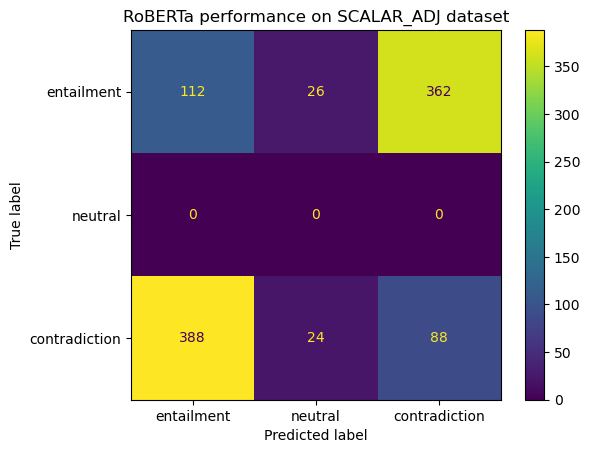

RoBERTa performance on SCALAR_ADJ dataset: 
     Accuracy: 0.2 
     Precision: [0.224      0.19555556] 
     Recall: [0.224 0.176] 
     F-score: [0.224      0.18526316] 



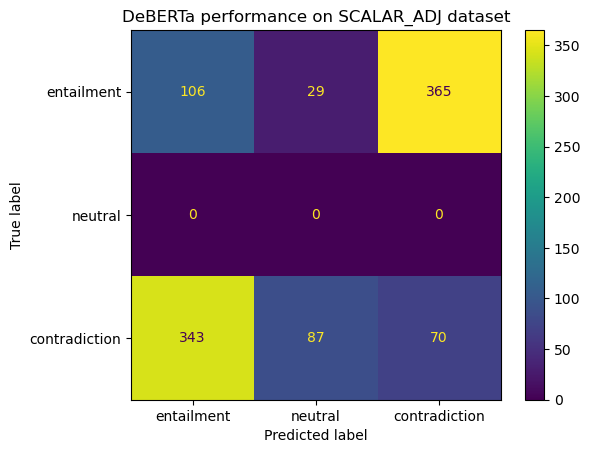

DeBERTa performance on SCALAR_ADJ dataset: 
     Accuracy: 0.176 
     Precision: [0.23608018 0.16091954] 
     Recall: [0.212 0.14 ] 
     F-score: [0.22339305 0.14973262] 



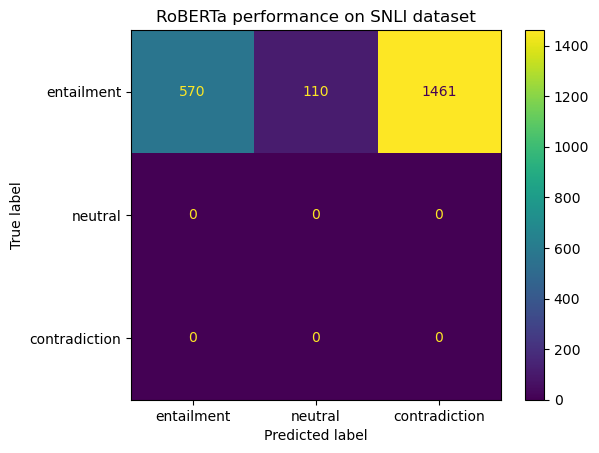

RoBERTa performance on SNLI dataset: 
     Accuracy: 0.2662307333021952 
     Precision: [1. 0.] 
     Recall: [0.26623073        nan] 
     F-score: [0.42050904 0.        ] 



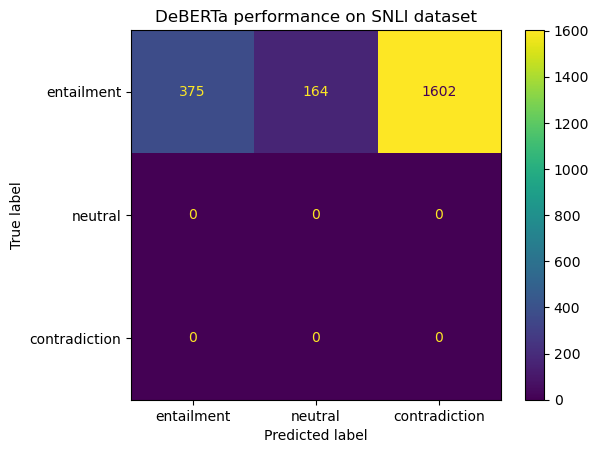

DeBERTa performance on SNLI dataset: 
     Accuracy: 0.17515179822512844 
     Precision: [1. 0.] 
     Recall: [0.1751518       nan] 
     F-score: [0.29809221 0.        ] 



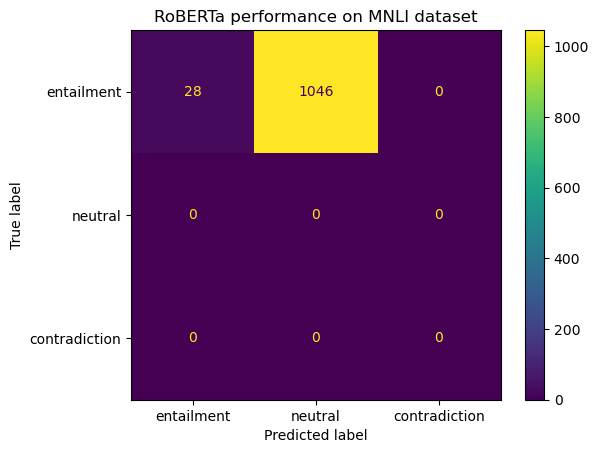

RoBERTa performance on MNLI dataset: 
     Accuracy: 0.0260707635009311 
     Precision: [ 1. nan] 
     Recall: [0.02607076        nan] 
     F-score: [0.0508167       nan] 



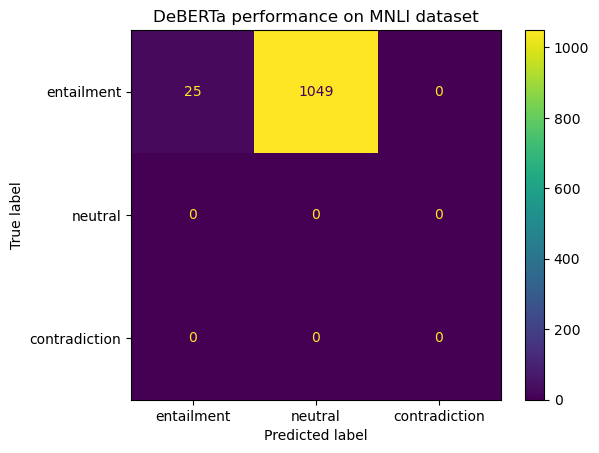

DeBERTa performance on MNLI dataset: 
     Accuracy: 0.023277467411545624 
     Precision: [ 1. nan] 
     Recall: [0.02327747        nan] 
     F-score: [0.04549591        nan] 



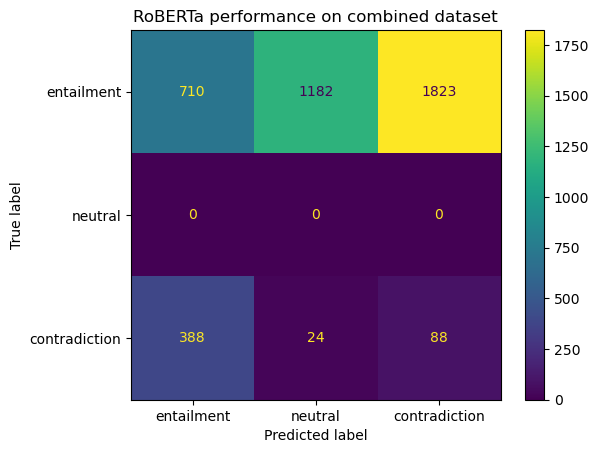

RoBERTa performance on combined dataset: 
     Accuracy: 0.1893238434163701 
     Precision: [0.64663024 0.04604919] 
     Recall: [0.19111709 0.176     ] 
     F-score: [0.29503428 0.07299876] 



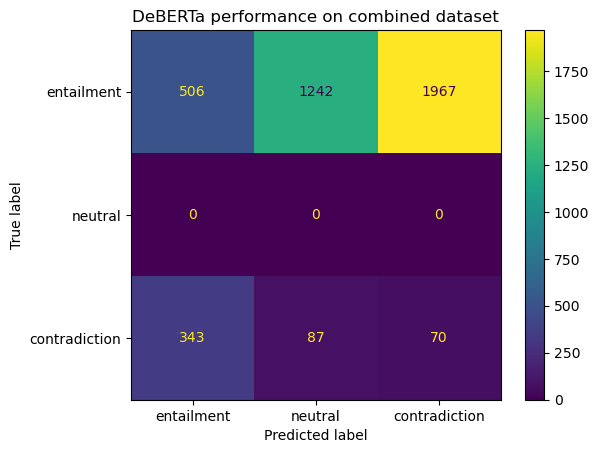

DeBERTa performance on combined dataset: 
     Accuracy: 0.13665480427046264 
     Precision: [0.59599529 0.03436426] 
     Recall: [0.13620458 0.14      ] 
     F-score: [0.22173532 0.05518329] 



In [2]:
from sklearn import metrics
import matplotlib.pyplot as plt

def get_metrics(dataframe : pd.DataFrame, model_title : str, dataset_title : str):
    """
    Method to print and save the confusion matrix and other performance metrics.
    """
    gold_labels = dataframe['Gold Label']
    model_predictions = dataframe[f'{model_title} Label']
    matrix = metrics.confusion_matrix(gold_labels, model_predictions, labels = ['entailment', 'neutral', 'contradiction'])
    display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = ['entailment', 'neutral', 'contradiction'])

    accuracy = metrics.accuracy_score(gold_labels, model_predictions)
    precision = metrics.precision_score(gold_labels, model_predictions, labels=['entailment', 'contradiction'], average=None, zero_division=np.nan)
    recall = metrics.recall_score(gold_labels, model_predictions, labels=['entailment', 'contradiction'], average=None, zero_division=np.nan)
    f_score = metrics.f1_score(gold_labels, model_predictions, labels=['entailment', 'contradiction'], average=None, zero_division=np.nan)
    
    display.plot()
    title = plt.title(f'{model_title} performance on {dataset_title} dataset').get_text()
    plt.savefig(f'data\\results\\{dataset_title}_{model_title}.png')
    plt.show()
    mets = f"{title}: \n \
    Accuracy: {accuracy} \n \
    Precision: {precision} \n \
    Recall: {recall} \n \
    F-score: {f_score} \n"

    print(mets)
    return mets


def analyse_results(excel_file_path : str, dataset_title : str):
    """
    Method to conveniently call the get_metrics() method for model performance of 
    both RoBERTa and DeBERTA. Also saves the performance metrics for one dataset 
    in a .txt file.
    """
    df = pd.read_excel(excel_file_path)
    roberta_metrics = get_metrics(df, 'RoBERTa', dataset_title)
    deberta_metrics = get_metrics(df, 'DeBERTa', dataset_title)
    with open(f'data\\results\\{dataset_title}_metrics.txt', 'w') as file:
        file.writelines([roberta_metrics, deberta_metrics])

analyse_results('data\\results\\results_custom.xlsx', 'SCALAR_ADJ')
analyse_results('data\\results\\results_snli.xlsx', 'SNLI')
analyse_results('data\\results\\results_mnli.xlsx', 'MNLI')
analyse_results('data\\results\\results_combined.xlsx', 'combined')